## Memory 
#### a searchable, long-term knowledge store that persists across multiple conversations.
### For production applications -> Vertex AI Memory Bank
https://www.kaggle.com/code/madisonchung/day-3b-agent-memory-yujinc/edit

In [2]:
from dotenv import load_dotenv
import os
from pathlib import Path

env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

# reference: https://stackoverflow.com/questions/16924471/difference-between-os-getenv-and-os-environ-get
try:
    api_key = os.environ["GOOGLE_API_KEY"]
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' in .env file. Details: {e}")

✅ Gemini API key setup complete.


In [1]:
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.memory import InMemoryMemoryService
from google.adk.tools import load_memory, preload_memory
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [3]:
async def run_session(
    runner_instance: Runner, user_queries: list[str] | str, session_id: str = "default"
):
    """Helper function to run queries in a session and display responses."""
    print(f"\n### Session: {session_id}")

    # Create or retrieve session
    try:
        session = await session_service.create_session(
            app_name=APP_NAME, user_id=USER_ID, session_id=session_id
        )
    except:
        session = await session_service.get_session(
            app_name=APP_NAME, user_id=USER_ID, session_id=session_id
        )

    # Convert single query to list
    if isinstance(user_queries, str):
        user_queries = [user_queries]

    # Process each query
    for query in user_queries:
        print(f"\nUser > {query}")
        query_content = types.Content(role="user", parts=[types.Part(text=query)])

        # Stream agent response
        async for event in runner_instance.run_async(
            user_id=USER_ID, session_id=session.id, new_message=query_content
        ):
            if event.is_final_response() and event.content and event.content.parts:
                text = event.content.parts[0].text
                if text and text != "None":
                    print(f"Model: > {text}")


print("✅ Helper functions defined.")

✅ Helper functions defined.


In [4]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

In [5]:
memory_service = (
    InMemoryMemoryService()
)  # ADK's built-in Memory Service for development and testing

In [6]:
# Define constants used throughout the notebook
APP_NAME = "MemoryDemoApp"
USER_ID = "demo_user"

# Create agent
user_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="MemoryDemoAgent",
    instruction="Answer user questions in simple words.",
)

print("✅ Agent created")

✅ Agent created


In [7]:
# Create Session Service
session_service = InMemorySessionService()  # Handles conversations

# Create runner with BOTH services
runner = Runner(
    agent=user_agent,
    app_name="MemoryDemoApp",
    session_service=session_service,
    memory_service=memory_service,  # Memory service is now available!
)

print("✅ Agent and Runner created with memory support!")

✅ Agent and Runner created with memory support!


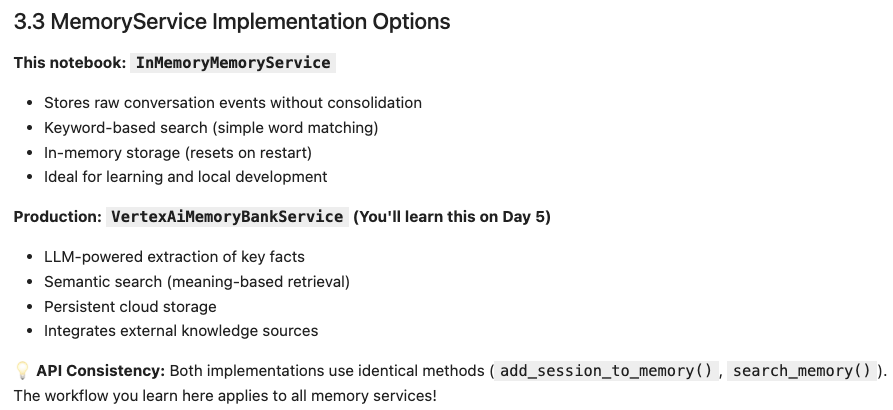

In [8]:
# User tells agent about their favorite color
await run_session(
    runner,
    "My favorite color is blue-green. Can you write a Haiku about it?",
    "conversation-01",  # Session ID
)


### Session: conversation-01

User > My favorite color is blue-green. Can you write a Haiku about it?
Model: > I can do that! Here is a haiku about blue-green:

Ocean meets the sky,
Turquoise dreams in gentle waves,
Nature's calming hue.


In [9]:
session = await session_service.get_session(
    app_name=APP_NAME, user_id=USER_ID, session_id="conversation-01"
)

# Let's see what's in the session
print("📝 Session contains:")
for event in session.events:
    text = (
        event.content.parts[0].text[:60]
        if event.content and event.content.parts
        else "(empty)"
    )
    print(f"  {event.content.role}: {text}...")

📝 Session contains:
  user: My favorite color is blue-green. Can you write a Haiku about...
  model: I can do that! Here is a haiku about blue-green:

Ocean meet...


In [10]:
# This is the key method!
await memory_service.add_session_to_memory(session)

print("✅ Session added to memory!")

✅ Session added to memory!


In [11]:
# Create agent
user_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="MemoryDemoAgent",
    instruction="Answer user questions in simple words. Use load_memory tool if you need to recall past conversations.",
    tools=[
        load_memory
    ],  # Agent now has access to Memory and can search it whenever it decides to!
)

print("✅ Agent with load_memory tool created.")

✅ Agent with load_memory tool created.


In [12]:
# Create a new runner with the updated agent
runner = Runner(
    agent=user_agent,
    app_name=APP_NAME,
    session_service=session_service,
    memory_service=memory_service,
)

await run_session(runner, "What is my favorite color?", "color-test")


### Session: color-test

User > What is my favorite color?


In [13]:
await run_session(runner, "My birthday is on March 15th.", "birthday-session-01")


### Session: birthday-session-01

User > My birthday is on March 15th.
Model: > Got it! I'll remember your birthday is on March 15th.


In [14]:
# Manually save the session to memory
birthday_session = await session_service.get_session(
    app_name=APP_NAME, user_id=USER_ID, session_id="birthday-session-01"
)

await memory_service.add_session_to_memory(birthday_session)

print("✅ Birthday session saved to memory!")

✅ Birthday session saved to memory!


In [15]:
# Test retrieval in a NEW session
await run_session(
    runner, "When is my birthday?", "birthday-session-02"  # Different session ID
)


### Session: birthday-session-02

User > When is my birthday?


Model: > I'm sorry, I don't have access to that information. Based on our previous conversation, I know your birthday is on March 15th.



In [16]:
# Search for color preferences
search_response = await memory_service.search_memory(
    app_name=APP_NAME, user_id=USER_ID, query="What is the user's favorite color?"
)

print("🔍 Search Results:")
print(f"  Found {len(search_response.memories)} relevant memories")
print()

for memory in search_response.memories:
    if memory.content and memory.content.parts:
        text = memory.content.parts[0].text[:80]
        print(f"  [{memory.author}]: {text}...")

🔍 Search Results:
  Found 4 relevant memories

  [user]: My favorite color is blue-green. Can you write a Haiku about it?...
  [MemoryDemoAgent]: I can do that! Here is a haiku about blue-green:

Ocean meets the sky,
Turquoise...
  [user]: My birthday is on March 15th....
  [MemoryDemoAgent]: Got it! I'll remember your birthday is on March 15th....


## Automatic Memory Storage with Callbacks

In [17]:
async def auto_save_to_memory(callback_context):
    """Automatically save session to memory after each agent turn."""
    await callback_context._invocation_context.memory_service.add_session_to_memory(
        callback_context._invocation_context.session
    )


print("✅ Callback created.")

✅ Callback created.


In [18]:
# Agent with automatic memory saving
auto_memory_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="AutoMemoryAgent",
    instruction="Answer user questions.",
    tools=[preload_memory],
    after_agent_callback=auto_save_to_memory,  # Saves after each turn!
)

print("✅ Agent created with automatic memory saving!")

✅ Agent created with automatic memory saving!
